In [1]:
# imports

from drn_interactions.io import load_derived_generic, load_eeg_raw, load_lfp_raw, load_lfp, load_eeg
from drn_interactions.transforms import SpikesHandler
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.signal import welch, medfilt
from scipy.stats import zscore
from scipy.ndimage import gaussian_filter
from sklearn.impute import KNNImputer
from sklearn.ensemble import IsolationForest
from scipy.signal import coherence
from sklearn.preprocessing import minmax_scale, robust_scale
from drn_interactions.config import Config
from drn_interactions.plots.heatmaps import state_indicator


In [2]:
sns.set_theme(context="paper", style="ticks")

In [3]:
# load data

def load_states(signal) -> pd.DataFrame:
    if signal == "eeg":
        df = load_derived_generic("eeg_states.csv")
    elif signal == "lfp":
        df = load_derived_generic("lfp_states.csv")
    else:
        raise ValueError(f"Unknown signal: {signal}")

    return df

def load_fft(signal):
    if signal == "eeg":
        df = load_eeg(block_name="pre")
    elif signal == "lfp":
        df = load_lfp(block_name="pre")
    else:
        raise ValueError(f"Unknown signal: {signal}")
    
    df["timepoint_s"] = df["timepoint_s"] - df["timepoint_s"].min()
    df = df.loc[lambda x: x.timepoint_s.between(0, 1800)]
    return df

def load_raw(signal) -> pd.DataFrame:
    if signal == "eeg":
        df = load_eeg_raw(block_name="pre")
    elif signal == "lfp":
        df = load_lfp_raw(block_name="pre")
    else:
        raise ValueError(f"Unknown signal: {signal}")
    
    df["timepoint_s"] = df["timepoint_s"] - df["timepoint_s"].min()
    df = df.loc[lambda x: x.timepoint_s.between(0, 1800)]
    return df


def load_spikes() -> pd.DataFrame:
    return SpikesHandler(block="pre", bin_width=1, t_start=0, t_stop=1800).spikes



In [4]:
# preprocess data

def preprocess_raw(df, session_name, new_interval_ms=100, medfilt_kernel=5):
    df = df.query("session_name == @session_name").copy()
    df = (
        df
        [["timepoint_s", "voltage"]]
        .assign(timepoint_s=lambda x: pd.to_timedelta(x.timepoint_s, unit="s"))
        .set_index("timepoint_s")
        .resample(f"{new_interval_ms}ms")
        .median()
    )
    df = df.apply(medfilt, kernel_size=medfilt_kernel)
    return df


def preprocess_spectrogram(df, session_name, remove_outliers=True, zscore_normalize=True):
    df = df.query("session_name == @session_name")
    df = df.loc[lambda x: (x.frequency < 8) & (x.frequency > 0)]
    df = df.pivot(index="timepoint_s", columns="frequency", values="fft_value")

    if remove_outliers:
        idx = IsolationForest().fit_predict(df)
        df.iloc[idx == -1, :] = np.nan 
        df = pd.DataFrame(KNNImputer().fit_transform(df), index=df.index, columns=df.columns)
    
    if zscore_normalize:
        df = df.apply(zscore).transpose().apply(zscore).transpose()
        values = gaussian_filter(df, sigma=(2, 2))
        df = pd.DataFrame(values, index=df.index, columns=df.columns)

    return df

def preprocess_spikes(df, session_name):
    df = df.query("session_name == @session_name")
    return df


def preprocess_state(df, session_name):
    df = df.query("session_name == @session_name")
    df = df.set_index("timepoint_s")
    return df

In [5]:
# plot data

def plot_spectrogram(df, ax, vmin=-2, vmax=2):
    sns.heatmap(df.T.iloc[::-1], cmap="viridis", cbar=False, vmin=vmin, vmax=vmax, ax=ax)
    ax.axis("off")
    return ax

In [6]:
# load data

states_lfp, states_eeg = load_states("lfp"), load_states("eeg")
fft_lfp, fft_eeg = load_fft("lfp"), load_fft("eeg")
raw_lfp, raw_eeg = load_raw("lfp"), load_raw("eeg")
spikes = load_spikes()


eeg_sessions = raw_eeg.session_name.unique()
lfp_sessions = raw_lfp.session_name.unique()
print(eeg_sessions)

['ESHOCK_01' 'ESHOCK_02' 'ESHOCK_03_LOC1' 'ESHOCK_04_LOC1'
 'ESHOCK_06_LOC1' 'ESHOCK_07_LOC1' 'ESHOCK_08_LOC1' 'ESHOCK_09_LOC1'
 'hamilton_10' 'hamilton_03' 'hamilton_04' 'hamilton_09' 'acute_15'
 'acute_16' 'acute_14' 'acute_12' 'acute_11']


## Example Data

In [7]:
session = "ESHOCK_03_LOC1"
sampling_interval_ms = 66.667

df_spectrum_lfp = preprocess_spectrogram(fft_lfp, session)
df_spectrum_eeg = preprocess_spectrogram(fft_eeg, session)
raw_lfp_session = preprocess_raw(raw_lfp, session, sampling_interval_ms)
raw_eeg_session =  preprocess_raw(raw_eeg, session, sampling_interval_ms)
spikes_session = preprocess_spikes(spikes, session)
lfp_states_session = preprocess_state(states_lfp, session)
eeg_states_session = preprocess_state(states_eeg, session)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


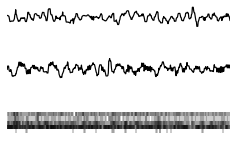

In [8]:
f = plt.figure(figsize=(4, 2.4))
start_idx = 600
duration = 500
start_time = start_idx * sampling_interval_ms / 1000
stop_time = start_time + (duration * sampling_interval_ms / 1000)
spiketrains = [
    pd.to_timedelta(neuron["spiketimes"].values, unit="s")
    for _, neuron in (
        spikes_session
        .loc[lambda x: x.spiketimes.between(start_time, stop_time)]
        .groupby("neuron_id")
        )
]

axes = f.subplots(3, 1, sharex=True, gridspec_kw=dict(height_ratios=[1.5, 1.5, 2], hspace=1.3))

ax_eeg, ax_lfp, ax_spikes = axes

raw_eeg_session.iloc[start_idx:start_idx+duration].transform(minmax_scale).plot(ax=ax_eeg, color="black")
raw_lfp_session.iloc[start_idx:start_idx+duration].transform(minmax_scale).plot(ax=ax_lfp, color="black")

ax_spikes.eventplot(spiketrains, color="black", linewidths=0.4, linelengths=1)

sns.despine(ax=ax_spikes, offset=0)
for ax in axes:
    ax.legend().remove()
    ax.axis("off")

f.savefig(Config.fig_dir / "bs_raw.png", dpi=300, bbox_inches="tight", transparent=True)

### Example Spectrograms

In [9]:
session = eeg_sessions[13]
# session = "hamilton_10"
print(session)
sampling_interval_ms = 66.667

df_spectrum_lfp = preprocess_spectrogram(fft_lfp, session)
df_spectrum_eeg = preprocess_spectrogram(fft_eeg, session)
lfp_states_session = preprocess_state(states_lfp, session)
eeg_states_session = preprocess_state(states_eeg, session)

raw_lfp_session = preprocess_raw(raw_lfp, session, sampling_interval_ms)
raw_eeg_session =  preprocess_raw(raw_eeg, session, sampling_interval_ms)


acute_16


[Text(0, 0, ''), Text(0, 1, '')]

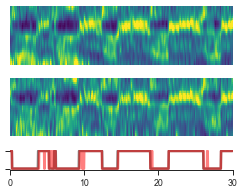

In [10]:
f = plt.figure(figsize=(4, 3))

ax_eeg, ax_lfp, ax_states = f.subplots(
    3, 1, sharex=False, gridspec_kw=dict(height_ratios=[1.5, 1.5, 0.5], hspace=0.3)
)

plot_spectrogram(df_spectrum_eeg, ax_eeg, vmin=-1, vmax=1)
plot_spectrogram(df_spectrum_lfp, ax_lfp, vmin=-1, vmax=1)

state_indicator(
    eeg_states_session["state"], order=["sw", "act"], ax=ax_states, 
    plot_kwargs=dict(
        label="eeg",
        color="black",
        alpha=0.5,
        linewidth=2.5
    )
)
state_indicator(
    lfp_states_session["state"],
    order=["sw", "act"],
    ax=ax_states,
    plot_kwargs=dict(
        label="lfp",
        color="red",
        alpha=0.5,
        linewidth=2.5
    )
)
ax_states.set_xlim(0, 1801)
ax_states.xaxis.set_major_locator(plt.MultipleLocator(600))
ax_states.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, pos: f"{x/60:.0f}"))
ax_states.set_yticklabels([])

# f.savefig(Config.fig_dir / "bs_lfp_eeg_spectrogram.png", dpi=300, bbox_inches="tight", transparent=True)

### State Overlap

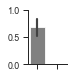

In [11]:
from sklearn.metrics import adjusted_mutual_info_score
from mchmm import MarkovChain

def mi(df, state_cols=("state_eeg", "state_lfp"), time_col="timepoint_s"):
    vals = df.sort_values(time_col)[list(state_cols)].values
    return adjusted_mutual_info_score(vals[:, 0], vals[:, 1])

def simulate_states_markov(df, state_cols=("state_eeg", "state_lfp"), time_col="timepoint_s"):
    df = df.sort_values(time_col).copy()

    for state_col in state_cols:
        df[state_col] = df[state_col]
        mc = MarkovChain().from_data(df[state_col].values)
        _, df[f"{state_col}"] = mc.simulate(len(df))
    return df



states = (
    states_lfp
    .merge(states_eeg, on=["session_name", "timepoint_s"], suffixes=("_lfp", "_eeg"))
    .query("quality_eeg == 'good'")
    .sort_values(["session_name", "timepoint_s"])
    .assign(data_set="Observed")
)

states_sim = simulate_states_markov(states).assign(data_set="Markov Simulated")

df_res = (
    pd.concat([states, states_sim])
    .groupby(["session_name", "data_set"])
    .apply(mi)
    .to_frame("mi")
    .reset_index()
    .merge(states[["session_name", "quality_eeg", ]].drop_duplicates())
)

f = plt.figure(figsize=(0.7, 1))

ax = f.subplots(1, 1)
sns.barplot(data=df_res, x="data_set", y="mi", ax=ax, color="grey", order=["Observed", "Markov Simulated"])

ax.set_ylim(0, 1)
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_xticklabels([])
sns.despine(fig=f)

f.savefig(Config.fig_dir / "bs_mi.png", dpi=300, bbox_inches="tight", transparent=True)

In [12]:
# transition matrix
import networkx as nx


def get_p_matrix(df, state_col="state_eeg", time_col="timepoint_s", sampling_interval_ms=66.667):
    df = df.sort_values(time_col).copy()
    mc_eeg: MarkovChain = MarkovChain().from_data(df[state_col].values)
    p_mat = mc_eeg.observed_p_matrix
    p_mat = pd.DataFrame(p_mat, columns=mc_eeg.states, index=mc_eeg.states)

    p_mat = p_mat.reset_index().rename(columns=dict(index="from")).melt(id_vars="from", var_name="to", value_name="p")
    return p_mat



edge_list = (
    states
    .groupby("session_name")
    .apply(get_p_matrix, state_col="state_eeg")
    .reset_index()
    .drop(columns="level_1")
    .groupby(["from", "to"])
    .apply(lambda x: pd.Series(dict(m=x["p"].mean(), s=x["p"].std())))
    .reset_index()
    .round(2)
    .assign(edge=lambda x: x.apply(lambda row: f"{row['m']} ± {row['s']}", axis=1))
)

edge_list

,from,to,m,s,edge
0,act,act,0.99,0.00,0.99 ± 0.0
1,act,sw,0.01,0.00,0.01 ± 0.0
2,sw,act,0.01,0.01,0.01 ± 0.01
3,sw,sw,0.99,0.01,0.99 ± 0.01
